# Problems in the Bicincitta data set from 2013

There are problems with the Bicincitta data that we need to address before loading the data into a reliable and proper data-base. We will point out these problems using examples, and measure their magnitude using systematic analysis, and then speculate about the source of these problems.


## Data
We will load the data from JSONs provided to us by Bicincitta at the end of April 2015. 


In [593]:
import os
import json
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

#because the strings in the jsons are web-quoted we will need to unquote them
import urllib

bikedatapath = os.path.join("Bicincitta_Drop", "datasets_2013")
stnfile = file(os.path.join(bikedatapath, "stations.json"), "r")
subnetfile =  file(os.path.join(bikedatapath, "subnetworks.json"), "r")             
userfile =  file(os.path.join(bikedatapath, "users.json"), "r")                       
trxnfile =  file(os.path.join(bikedatapath, "transactions.json"), "r")                       

subnets = json.load(subnetfile)[u'RECORDS']
subnetfile.close()
stations = json.load(stnfile)[u'RECORDS']
stnfile.close()
users = json.load(userfile)[u'RECORDS']
userfile.close()
trxns = json.load(trxnfile)[u'RECORDS']
trxnfile.close()

The resulting data is in the form of lists of dictionaries. We can take a peek at the keys in each of the four data types, by creating a data frame and displaying the first few rows.

In [733]:
print "a subnetwork is described by, "
for k in subnets[0].keys():
    print "\t", k
print "\n a station is described by," 
for k in stations[0].keys():
    print "\t", k
    
print "\n a user is described by "
for k in users[0].keys():
    print "\t", k
    
print "\n a transaction is described by, " 
for k in trxns[0].keys():
    print "\t", k

a subnetwork is described by, 
	id
	name

 a station is described by,
	name
	longitude
	subnetwork_name
	latitude
	id
	subnetwork_id

 a user is described by 
	subnetwork_id
	gender
	expires
	postal_code
	subnetwork_name
	address
	id

 a transaction is described by, 
	direction
	user_id
	station_id
	event_time
	id


The resulting dictionaries have ids that are UTF-8 strings. We can change these to integers to make our work easier,

In [600]:
for sn in subnets:
    sn['id'] = int(sn['id'])
    
for st in stations:
    st['id'] = int(st['id'])
    st['subnetwork_id'] = int(st['subnetwork_id'])
    st['name'] = urllib.unquote_plus(st['name'])    
    
for u in users:
    u['subnetwork_id'] = int(u['subnetwork_id'])
    u['id'] = int(u['id'])
    u['address'] = urllib.unquote_plus(u[u'address'])
    
for t in trxns:
    t['id'] = int(t['id'])
    t['station_id'] = int(t['station_id'])
    t['user_id'] = int(t['user_id'])
    


There are keys in a transaction that do not seem to correspond to the data, but refer to the time at which the data was loaded into the JSON provided to us. We will drop these variables, and change the *event_time* to a time object. Following that we will sort the transactions by the event time

In [601]:
from datetime import datetime

trxns = [ {u'direction': t[u'direction'],
           u'user_id': t[u'user_id'],
           u'event_time': datetime.strptime(t[u'event_time'],
                                            "%m/%d/%Y %H:%M:%S"),
           u'station_id': t[u'station_id'],
           u'id': t[u'id']}
         for t in trxns]

trxns = sorted(trxns, key = lambda t: t[u'event_time'])

We also sort the subnetworks and stations by their *id*.

In [602]:
subnets = sorted(subnets, key = lambda s: s[u'id'])
stations = sorted(stations, key = lambda s:s[u'id'])

Stations and users have been assigned a *subnetwork_id* in the data. We can add the subnetwork name to these data,

In [603]:
for s in stations:
    s[u'subnetwork_name'] = subnets[s['subnetwork_id'] - 1][u'name']

for u in users:
    i = u['subnetwork_id'] - 1
    if i < len(subnets):
        u[u'subnetwork_name'] = subnets[i][u'name']
    else:
        u[u'subnetwork_name'] = u'unknown'

##Who are the users?

The simplest question may be the fraction of females vs males,

In [794]:
numFemales = 1.*sum(u['gender'] == "F" for u in users)
numMales = 1.*sum(u['gender'] == "M" for u in users)

print "Of all the users ", int(100*numFemales/len(users)), " percent are female ", \
"and ", int(100*numMales/len(users)), " percent males."

Of all the users  60  percent are female  and  39  percent males.


It would be interesting if 60% of the users were in fact female. However, as we will see later there seems to be a problem of user duplicacy biased towards females. 

## Subnetworks for stations and users
Are the *subnetwork_id*s for stations and users sensible? The subnetworks that the stations fall in are

In [604]:
stn_sns = set( [s[u'subnetwork_id'] for s in stations] )
subnetsWithStns = [ s for s in subnets if s[u'id'] in stn_sns]
print "Subnetworks that have stations assigned to them"
pd.DataFrame(subnetsWithStns)

Subnetworks that have stations assigned to them


,id,name
0,1,La Cote
1,2,Agglo Fribourg
2,3,Bulle
3,4,Les Lacs-Romont
4,6,Chablais
5,7,Valais Central
6,8,Yverdon-les-Bains
7,9,Lausanne-Morges
8,10,Campus
9,11,Riviera


We see that stations  cover only 11 of the 18 subnetworks. Looking at the subnetworks with no stations, 

In [605]:
subnetsWithoutStns = [ s for s in subnets if s[u'id'] not in stn_sns]
print "Subnetworks without any assigned stations"
pd.DataFrame(subnetsWithoutStns)

Subnetworks without any assigned stations


,id,name
0,5,Bâle
1,13,PubliBike
2,14,Vevey
3,15,Morges
4,16,Ouchy
5,17,Paradiso
6,18,Cern


we can see why there are no stations corresponding to these subnetworks. Basel, and Cern because Bicincitta have not given us data for these regions. Vevey, Morges, Ouchy, and Paradiso include stations subsumed by other subnetworks. These networks may be a remnant from previous versions of the data. This leaves **PubliBike** unexplained. As it turns out, there are users that have been assigned the subnetwork PubliBike (*id* 13). In fact we see later that the users who have registered transactions in the data have been assigned only PubliBike, and no other subnetwork.

In [606]:
users_pub = [u for u in users if u[u'subnetwork_id'] == 13]
print "Number of users from subnetwork PubliBike", len(users_pub)

Number of users from subnetwork PubliBike 58927


Users that have been assigned subnetwork PubliBike compose 70% of the total users in the data. However we are not going to see PubliBike in any of their transactions as there are no stations for the subnetwork PubliBike! What about other subnetworks without stations?

In [607]:
user_sns = set(u['subnetwork_id'] for u in users)

subnetsWithUsers = [ s for s in subnets if s[u'id'] in user_sns]

print "subnetworks assigned to users"
pd.DataFrame(subnetsWithUsers)

subnetworks assigned to users


,id,name
0,2,Agglo Fribourg
1,6,Chablais
2,7,Valais Central
3,8,Yverdon-les-Bains
4,9,Lausanne-Morges
5,10,Campus
6,12,Lugano-Paradiso
7,13,PubliBike
8,14,Vevey
9,16,Ouchy


In [608]:
print "subnets without any users"
subnetsWithoutUsers = [ s for s in subnets if s[u'id'] not in user_sns]
pd.DataFrame(subnetsWithoutUsers)

subnets without any users


,id,name
0,1,La Cote
1,3,Bulle
2,4,Les Lacs-Romont
3,5,Bâle
4,11,Riviera
5,15,Morges


Comparing the subnets for users to subnets with stations we see that there are **only 7 subnets** for which we have stations as well as users,

In [609]:
print "subnets with stations as well as users"
subnetsValid = [s for s in subnets if s[u'id'] in user_sns and s[u'id'] in stn_sns]
pd.DataFrame(subnetsValid)

subnets with stations as well as users


,id,name
0,2,Agglo Fribourg
1,6,Chablais
2,7,Valais Central
3,8,Yverdon-les-Bains
4,9,Lausanne-Morges
5,10,Campus
6,12,Lugano-Paradiso


As a summary, let us tabulate the fraction of users in each of the subnets,

In [610]:
all_sns = list(set(s['id'] for s in subnets).union(set(u['subnetwork_id'] for u in users)))
all_sns_names = {i: subnets[i - 1][u'name'] if i <= len(subnets) 
                                             else 'unknown'
                  for  i in all_sns}
subnet_numUsers = [{u'id': i,
                    u'name': all_sns_names[i],
                    u'numUsers': user_sns_list.count(i)}
                   for i in all_sns]
subnet_numUsers = sorted(subnet_numUsers, key=lambda s: s[u'numUsers'] )

In [611]:
pd.DataFrame(subnet_numUsers)

,id,name,numUsers
0,1,La Cote,0
1,3,Bulle,0
2,4,Les Lacs-Romont,0
3,5,Bâle,0
4,11,Riviera,0
5,15,Morges,0
6,6,Chablais,3
7,16,Ouchy,3
8,17,Paradiso,3
9,14,Vevey,4


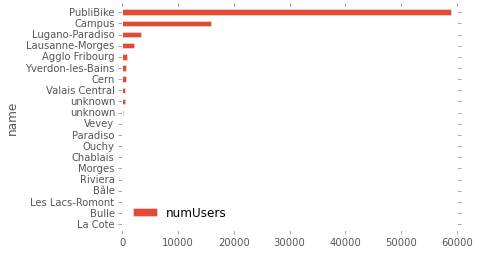

In [612]:
sn_nu = pd.DataFrame(subnet_numUsers)[  ['name', 'numUsers']] 
sn_nu.index = sn_nu.name
sn_nu.plot(kind="barh")

So, most of the users are in PubliBike, which could create a problem as there are no stations associated to PubliBike. Lets first look at the transactions before we try to find a solution to this problem.

##Transaction users, stations, and subnetworks

We begin by looking at how many users actually use the bike system ( have valid transactions)

In [613]:
trxn_users = set( t['user_id'] for t in trxns)
print "fraction of users who have registered a transaction", (1.*len(trxn_users))/len(users)

fraction of users who have registered a transaction 0.10673152586


Only 10% users have registered a transaction! Are all the transactions of a user in the same subnetwork?

In [742]:
users_d = { u[u'id']: u for u in users}

user_trxn_stations = {u: {u'user_id': u,
                          u'stations': set(),
                          u'numTrxns': 0,
                          u'assigned_subnet': users_d[u][u'subnetwork_id']}
                      for u in trxn_users }

stn_subnet = { s[u'id']: s[u'subnetwork_id'] for s in stations}

for t in trxns:
    uid = t[u'user_id']
    user_trxn_stations[uid][u'stations'].add( t[u'station_id'])
    user_trxn_stations[uid][u'numTrxns'] += 1
    
for u in user_trxn_stations.keys():
    user = user_trxn_stations[u]
    user[u'numStations'] = len(user[u'stations'])
    user[u'stn_subnets'] = set( stn_subnet[s] for s in user[u'stations'] )
    user[u'numSubnets'] = len(user[u'stn_subnets'])


In [800]:
user_stations = pd.DataFrame(user_trxn_stations.values()).sort(['numStations'], 
                                                               ascending=False)
user_stations[['user_id','assigned_subnet', 'numStations', 
               'numSubnets', 'numTrxns']].head()

,user_id,assigned_subnet,numStations,numSubnets,numTrxns
3462,108132,13,56,8,2180
4469,111523,13,46,7,2110
5399,84545,13,43,7,5134
3463,108133,13,43,6,3280
4673,112287,13,23,3,540


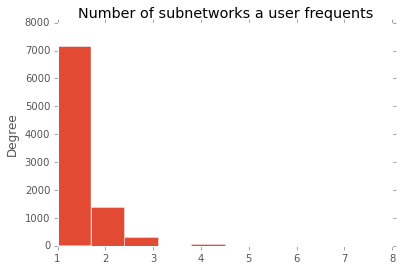

In [759]:
user_stations['numSubnets'].plot(kind="hist", bins=10,
                                 title="Number of subnetworks a user frequents" )

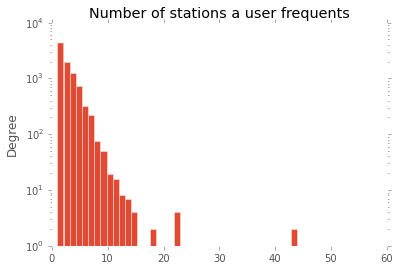

In [758]:
user_stations['numStations'].plot(kind='hist', logy=True, bins = 50,
                                  title="Number of stations a user frequents")
#stns = [ u[u'numStations'] for u in user_trxn_stations.values()]
#dict(zip(set(stns), [stns.count(s) for s in set(stns)]))

A simple question might guide us. How many transactions belong to Publibike users ( who have subnetwork_id PubliBike) ?

In [760]:
trxn_user_subnets = [users_d[t[u'user_id']] [u'subnetwork_id'] for t in trxns]
print "The subnetworks of the users who make transactions make a", set(trxn_user_subnets)

The subnetworks of the users who make transactions make a set([13])


So, **from the view point of the users, all the transactions are in the subnetwork PubliBike**

How many transactions in a subnetwork of the stations?

In [761]:
stations_d = { s[u'id']: s for s in stations}
trxn_stn_subnets = [ stations_d[t[u'station_id']] [u'subnetwork_id'] for t in trxns ]

Now we can make a table for subnetworks, counting the number of trxns through user and station *subnetwork_id*, in addition to the number of users.

In [762]:
all_sns = list(set(s['id'] for s in subnets).union(set(u['subnetwork_id'] for u in users)))
all_sns_names = {i: subnets[i - 1][u'name'] if i <= len(subnets) 
                                             else 'unknown'
                  for  i in all_sns}
stn_sns = [ s[u'subnetwork_id'] for s in stations]
subnet_nums = [{u'id': i,
                u'name': all_sns_names[i],
                u'numStations': stn_sns.count(i),
                u'numUsers': user_sns_list.count(i),
                u'numTrxns_stns': trxn_stn_subnets.count(i),
                u'numTrxns_users': trxn_user_subnets.count(i) }
               
                   for i in all_sns]
subnet_nums = sorted(subnet_nums, key=lambda s: s[u'numUsers'] )

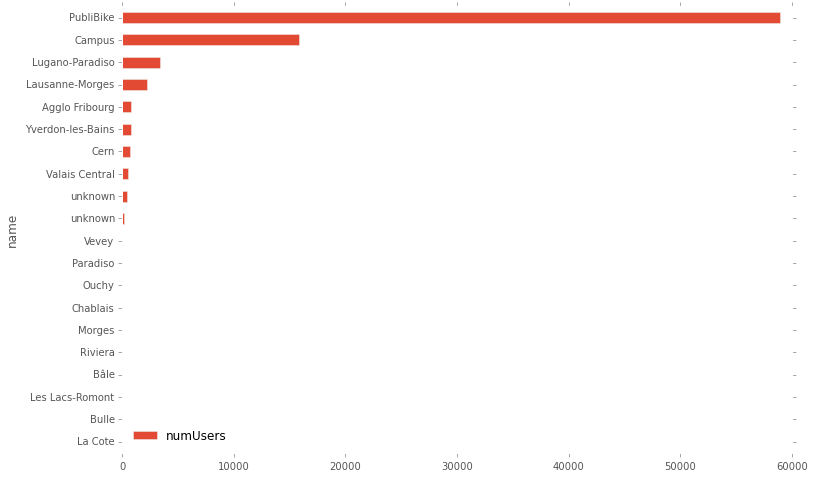

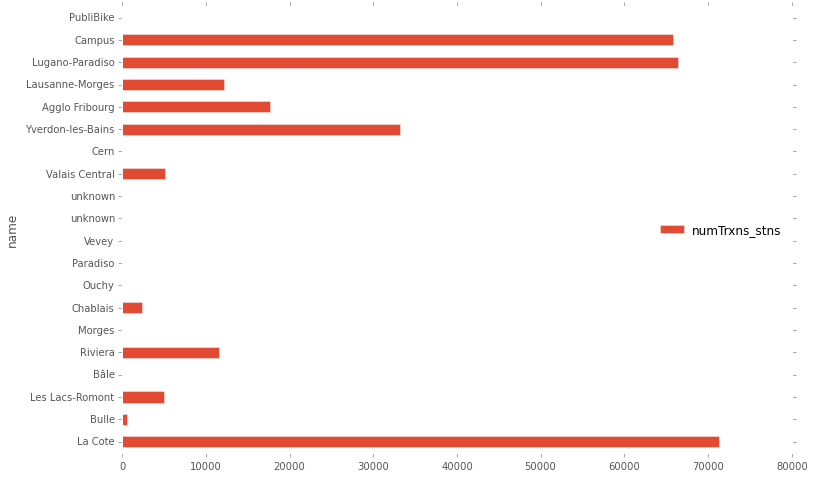

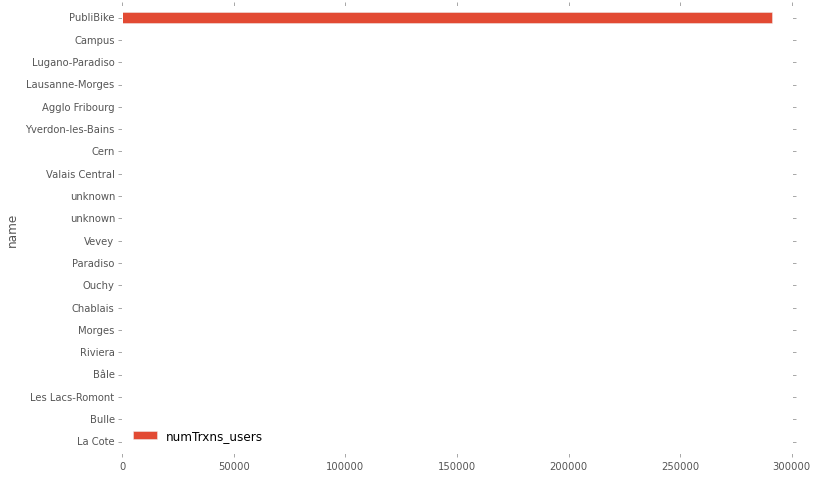

In [763]:
subnet_nums_df = pd.DataFrame(subnet_nums)
subnet_nums_df.index = subnet_nums_df.name
subnet_nums_df[["numUsers"]].plot(kind="barh", figsize=(12,8))
subnet_nums_df[["numTrxns_stns"]].plot(kind="barh",  figsize=(12,8))
subnet_nums_df[["numTrxns_users"]].plot(kind="barh", figsize=(12,8))

In [764]:
subnet_nums_df = subnet_nums_df.sort(['numStations'])
pd.DataFrame(subnet_nums_df)

,id,name,numStations,numTrxns_stns,numTrxns_users,numUsers
name,,,,,,
Vevey,14,Vevey,0,0,0,4
Cern,18,Cern,0,0,0,721
unknown,2005,unknown,0,0,0,469
unknown,2011,unknown,0,0,0,152
Paradiso,17,Paradiso,0,0,0,3
Ouchy,16,Ouchy,0,0,0,3
PubliBike,13,PubliBike,0,0,291134,58927
Morges,15,Morges,0,0,0,0
Bâle,5,Bâle,0,0,0,0


## User addresses 

There are several problems associated with user addresses. We have already noticed, and fixed, that the provided addresses in the JSON have not been *unquoted* from their web encoding. Here we continue to explore other problems that may arise in the addresses.

We want to count the number of users at one address. Because the addresses have been provided as strings, we have to be able to aggregate all address strings that describe the same address. We have written a python function to do this task, which takes the address and postal-code strings to provide a combined string taking into account some empirical disambiguation criteria such as *Av, Ave*, for *Avenue*. 

In [766]:
users_with_adr = [u for u in users if u[u'address'] != '']

In [769]:
def addressWithZip(a, z):
    #some zip codes have 5 figures, clearly wrong for CH
    if type(z) != str: z = str(z)
    try:
        z = "".join(list(z)[0:4]).encode("utf-8")
    except:
        z = ""
    az = (strip(a) + "; " + strip(z)).lower()
    az = az.replace("av ", "avenue ").replace("ch ", "chemin ")
    az = az.replace("ch. ", "chemin ").replace("av. ", "avenue ").encode("utf-8")
    return az.replace("ave. ", "avenue ")
    
uadr = [addressWithZip(u[u'address'], u[u'postal_code'])
        for u in users_with_adr]

uuadr = list(set(uadr))
print "number of users with available address", len(uadr)
print "number of these addresses that are unique", len(uuadr)

number of users with available address 21659
number of these addresses that are unique 15446


In [770]:
users_byAddr = { a: [] for a in uuadr}

for u in users_with_adr:
    a = addressWithZip(u[u'address'], u[u'postal_code'])
    users_byAddr[a].append( {u'gender': u[u'gender'],
                             u'addressOriginal': u[u'address'],
                             u'id': u[u'id'],
                             u'subnetwork_id': u[u'subnetwork_id'],
                             u'expires': u[u'expires']})
                                         
addr_numUsers = sorted([(k, len(v)) for k, v in users_byAddr.items()], key=lambda (k, l): -l)

What fraction of unique addresses have multiple users?

In [771]:
print (1.*sum(  l > 1 for k, l in addr_numUsers))/len(addr_numUsers)

0.230545124951


How many users at addresses with multiple users?

In [772]:
print sum( l for k, l in addr_numUsers if l > 1)

9774


which corresponds to a fraction of all users with available address,

In [773]:
print (1.*sum( l for k, l in addr_numUsers if l > 1))/len(users_with_adr)

0.451267371531


Multiple users at the same address could be actual multiple people, or multiple registrations by the same person, or a glitch in the data. We can consider as an example the address with the most multiplicity of 53,

In [775]:
print "address: ", addr_numUsers[0][0], ", number of users: ", addr_numUsers[0][1]
#pd.DataFrame(users_byAddr[addr_numUsers[0][0]]).head()  

address:  via lambertenghi 1; 6900 , number of users:  53


We could say more about the multiple users at the same address if we look at their transactions. However as it turns out, we **do not have addresses for users who have registered transactions in the data**,

In [778]:
print( any( users_d[uid][u'address'] != u'' for uid in trxn_users))

False


We can look at the subnetwork with addresses assigned to the *multi* users,

In [779]:
users_uniqueAdr = {a: us for a, us in users_byAddr.items()
                   if len(us) == 1}

users_multiAdr = {a: us for a, us in users_byAddr.items() 
                  if len(us) > 1}

users_multiAdr_sns = [list(set(u[u'subnetwork_id'] for u in us))
                      for a, us in users_multiAdr.items()]

users_multiAdr_multiSN = { a: us for a, us in users_multiAdr.items()
                          if len( set(u[u'subnetwork_id'] for u in us)) > 1}
print "subnetworks with addresses assigned to multiple users", set([ s for sns in users_multiAdr_sns for s in sns ])

subnetworks with addresses assigned to multiple users set([2, 7, 8, 9, 10, 12, 18, 2005, 2011])


Some of the multi-user addresses have more than one subnetworks ( through the users at that address) 

In [786]:
print "Subnetworks for users living at addresses with multiple registered users"
subnets_d = {s[u'id']: s for s in subnets}

multiAdrMultiSN = []
for a, us in users_multiAdr_multiSN.items():
    snnames = set(subnets_d[s][u'name'] if subnets_d.has_key(s) else str(s) 
                  for s in set(u[u'subnetwork_id'] for u in us))
    multiAdrMultiSN.append( {u'address': a,
                             #u'addressOriginal': us[0]['addressOriginal'],
                             u'numFemales': sum(u['gender'] == "F" for u in us),
                             u'numMales': sum(u['gender'] == "M" for u in us),
                             u'numUsers': len(us),
                             u'subnetworks': snnames})
    
#print(pd.DataFrame(multiAdrMultiSN).to_string())
multiAdrSN_df = pd.DataFrame(multiAdrMultiSN).sort(['numUsers'], ascending=False)


Subnetworks for users living at addresses with multiple registered users


There are as many as 37 users assigned to the same address that also have more than subnetwork assigned. Addresses with several users might represent problems of multiple subscription. For example, if we look at addresses with more than 10 users, 

In [806]:
multiAdrSN_df[ multiAdrSN_df.numUsers > 10]

,address,numFemales,numMales,numUsers,subnetworks
143,avenue des bains 9; 1007,37,0,37,"set([Lausanne-Morges, Campus])"
40,route cantonale 33; 1025,25,0,25,"set([Lausanne-Morges, Campus])"
105,avenue des bains 11; 1007,23,0,23,"set([Lausanne-Morges, Campus])"
48,place du tunnel 17; 1005,23,0,23,"set([Lausanne-Morges, Campus])"


we see that the user is over-whelmingly females. However, a look at the lower end of such addresses seems alright,

In [807]:
multiAdrSN_df[ multiAdrSN_df.numUsers < 4].head()

,address,numFemales,numMales,numUsers,subnetworks
3,poudrière 24; 1950,3,0,3,"set([Campus, Valais Central])"
61,avenue beaulieu 20; 1004,2,1,3,"set([Lausanne-Morges, Campus])"
23,avenue louis-ruchonnet 31; 1003,2,1,3,"set([Lausanne-Morges, Campus])"
104,eichenweg 12; 1718,2,1,3,"set([Agglo Fribourg, Campus])"
67,rue saint-rochemin 5; 1004,2,1,3,"set([Lausanne-Morges, Campus])"


These particular addresses appear sensible. There could be more than one person living at these addresses who have signed up with the bike system, albeit in different subnetworks. Or may be it is the same person with 2 different sign-ups in two different sub-networks. This raises the question: **How are users registered by the system? One individual = one signup? Or does a user need a sign-up for each subnetwork that she wants to use?** If it is the latter, then the provided *user_ids* become less useful, because the same individual will appear as different users according to the *user_ids*. 

In [808]:
multiAdr = []
for a, us in users_multiAdr.items():
    snnames = set(subnets_d[s][u'name'] if subnets_d.has_key(s) else str(s) 
                  for s in set(u[u'subnetwork_id'] for u in us))
    multiAdr.append( {u'address': a,
                      u'numUsers': len(us),
                      u'numMales': sum(u['gender'] == "M" for u in us),
                      u'numFemales': sum(u['gender'] == "F" for u in us),
                      u'subnetworks': snnames})
 


#print(pd.DataFrame(multiAdrMultiSN).to_string())
multiAdr_df = pd.DataFrame(multiAdr).sort(['numUsers'], ascending=False)
multiAdr_df[['address', 'numFemales',
             'numMales', 'numUsers']][multiAdr_df['numUsers'] > 20]

,address,numFemales,numMales,numUsers
18,via lambertenghi 1; 6900,52,1,53
2288,chemin des falaises 3; 1005,52,0,52
1349,chemin des berges 12; 1022,41,0,41
2150,avenue des bains 9; 1007,37,0,37
332,via monte carmen 4; 6900,33,0,33
287,route cantonale 33; 1025,25,0,25
1444,via madonnetta 23; 6900,24,0,24
1649,place du tunnel 17; 1005,23,0,23
1826,avenue des bains 11; 1007,23,0,23
1997,rue de genève 76; 1004,22,0,22


In [809]:
uniqueAdr = []

for a, us in users_uniqueAdr.items():
    snnames = set(subnets_d[s][u'name'] if subnets_d.has_key(s) else str(s) 
                  for s in set(u[u'subnetwork_id'] for u in us))
    uniqueAdr.append( {u'address': a,
                      u'numUsers': len(us),
                      u'numMales': sum(u['gender'] == "M" for u in us),
                      u'numFemales': sum(u['gender'] == "F" for u in us),
                      u'subnetworks': snnames})
    
uniqueAdr_df = pd.DataFrame(uniqueAdr)
uniqueAdr_df[['address', 'numFemales',
              'numMales', 'numUsers']].head()

,address,numFemales,numMales,numUsers
0,bonne-espérance 28; 1006,1,0,1
1,37 route cantonnale; 1025,1,0,1
2,avenue de la dôle 4; 1005,1,0,1
3,abbesses 21; 2012,1,0,1
4,chemin de ponfilet 100; 1093,0,1,1
